# Final project, Numerical Analysis 2018-2019


## Project description

In this project, we would like to compare the performance of some embarassingly simple algorithms to solve a classification problem based on the MNIST database. 

The abstract aim of the program is to write a function:

```
result = classify(image)
```

that takes as input a small grey scale image of a hand-written digit (from the MNIST database), and returns the digit corresponding to the content of the image.

An example of the images we'll be working on is the following:

![mnist examples](https://m-alcu.github.io/assets/mnist.png)

Some background on the MNIST database (from wikipedia):


## MNIST database

*From Wikipedia, the free encyclopedia*

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

## MNIST sample images.

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. There have been a number of scientific papers on attempts to achieve the lowest error rate; one paper, using a hierarchical system of convolutional neural networks, manages to get an error rate on the MNIST database of 0.23%. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support vector machine to get an error rate of 0.8%. An extended dataset similar to MNIST called EMNIST has been published in 2017, which contains 240,000 training images, and 40,000 testing images of handwritten digits and characters.

## Algorithm

We start by defining the distance between two images. Ideally, a distance function between two images is zero when the images are the same, and greater than zero when the images are different. 

The bigger the distance, the more different the images should be. Ideally, the distance between an image of the number `9` should be closer to an image of the number `8` than to an image of the number `1` (the digits `9` and `8`, as images, differ by the fact that the first has one closed loop, while the second has two closed loops, while the digit `1` is mostly a straight line). Two different images representing the same number should be even closer (i.e., the distance function should return a "small" number).

Given a distance and a training set of images for which we know everything, the simplest algorithm we can think of to classify an image `z`, is the following: given a set of train images (`x_train`) for which we know the digit they represent (`y_train`), measure the distance between `z` and all images in `x_train`, and classify the image `z` to represent the same digit of the image that is closest to `z` in `x_train`:

Parameters of the algorithm:

- `x_train`
- `y_train`
- a distance function `dist`  

Input of the function

- `z`

Output of the function

- `digit`

where 

```
def classify(z):
    all_distances = array([dist(x, z) for x in x_train])
    digit = y_train[argmin(all_distances)]
    return digit
```

We will experiment with different distances, and we will try to improve the algorithm above in a step by step fashon.

## Data description

Each image in the MNIST dataset represents a hand written digit, in the form of a matrix of `28x28` values between zero and one, representing gray scale values (zero = white, one = black).

We use an array of `60.000x28x28` floating point values to collect all training images, and an array of `60.000` digits containing the (correct) value of the training digits (between 0 and 9 inclusive).

The testing images are instead collected into two arrays of size `10.000x28x28` and `10.0000` respectively.

In [14]:
%pylab inline

# input image dimensions
img_rows, img_cols = 28, 28

# Uncomment the following lines if you have keras installed. Otherwise you can 
# use the file I uploaded: mnist.npz
import keras
from keras.datasets import mnist
from keras import backend as K

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training set: ', x_train.shape)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols) #
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)
    input_shape = (img_rows, img_cols)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 #Normalization factor
x_test /= 255

# np.savez_compressed('mnist.npz', x_train, y_train, x_test, y_test)

# arc = load('mnist.npz')
# x_train = arc['arr_0']
# y_train = arc['arr_1']
# x_test  = arc['arr_2']
# y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Populating the interactive namespace from numpy and matplotlib
Training set:  (60000, 28, 28)
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [15]:
# Define some decorators to measure time

#adapted from Fluent Python and Alberto's Advance Programming Course
import functools
def args_to_string(*args,**kw):
    arg_str = []
    if args:
        arg_str.append(','.join(str(arg) for arg in args))
    if kw:
        arg_str.append(', '.join(('{0}={1}'.format(k,v) for k,v in kw.items())))
    return ','.join(a for a in arg_str)

import time
def time_this(func):
    def decorated(*args,**kw):
        t0 = time.perf_counter()
        result = func(*args,**kw)
        t1 = time.perf_counter()
        name = func.__name__
#         arg_str = args_to_string(*args,**kw)
        #print('{0}({1}): [{2}]'.format(name, arg_str,t1-t0))
        #print('{}({}): [{}]'.format(name, arg_str,t1-t0))
#         print('%s(%s): [%0.8fs]' % (name, arg_str, t1-t0))
        print('%s: [%0.8fs]' % (name, t1-t0))
        return result
    return decorated


class Timer():
    def __init__(self):
        self._start = 0
    def __enter__(self):
        self._start = time.time()
        return self	

    def __exit__(self, exc_type, exc_value, traceback):
        print("Total time = ", time.time() - self._start) 
        return True


# Plotting one image

How do we plot the images? `pyplot`, which has been imported by the first line of the previous cell, contains a command called `imshow`, that can be used to plot images. 

In this case we know it is a greyscale image, with zero representing white and one representing black, so we use a colormap that goes from white to black, i.e., `gray_r` where `_r` stands for reversed. 

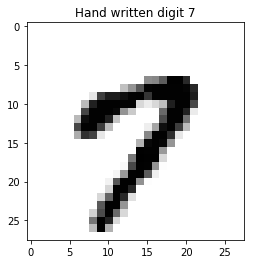

In [16]:
# Show image number 15, and write in the title what digit it should correspond to
N=15
imshow(x_train[N], cmap='gray_r')
_ = title('Hand written digit '+str(y_train[N]))

**IF YOU DON'T HAVE ENOUGH COMPUTATIONAL POWER, RUN THE EXERCISES ONLY UP TO WHAT IS SUSTAINABLE FOR YOUR PC**

General guidelines:

- Time all functions you construct, and try to make them run as fast as possible by precomputing anything that can be precomputed
- Extra points are gained if you reduce the complexity of the given algorithms in any possible way, for example by exploiting linearity, etc.
- If something takes too long to execute, make sure you time it on a smaller set of input data, and give estimates of how long it would take to run the full thing (without actually running it). Plot only the results you manage to run on your PC.

# Assignment 1

Implement the following distance functions

- d_infty $$ d_{\infty}(a,b) := \max_{i,j} |b_{ij}-a_{ij}|$$
- d_one $$ d_1(a,b) := \sum_{i,j} |b_{ij}-a_{ij}|$$
- d_two $$ d_2(a,b) := \sqrt{\sum_{i,j} |b_{ij}-a_{ij}|^2}$$

that take two `(28,28)` images in input, and return a non-negative number.

In [30]:
def d_infty(A, B):
    return np.max( abs(B-A) )

def d_1(A,B):
    return np.sum( (np.abs(A-B)) )

def d_2(A,B):
    return np.sqrt( np.sum( np.square(A-B) ) )
    
# we print this to have some numbers as reference
print(d_infty(x_train[0], x_train[1]))
print(d_1(x_train[0], x_train[1]))
print(d_2(x_train[0], x_train[1]))

print("----------")

print(d_infty(x_train[10], x_train[11]))
print(d_1(x_train[10], x_train[11]))
print(d_2(x_train[10], x_train[11]))

1.0
115.70979
9.361222
----------
0.99607843
133.4902
10.567111



# Assignment 2

Write a function that, given a number `N`, and a distance function `dist`, computes the distance matrix D of shape `(N,N)` between the first `N` entries of `x_train`:

```
D[i,j] = dist(x_train[i], x_train[j])
```

performing the **minimum** number of operations (i.e., avoid computing a distance if it has already been computed before, i.e., keep in mind that dist(a,b) = dist(b,a)).


## Assignment 2: solution

For this assignment we implemented two solutions (`dist_1(...)` and `dist(...))2`) and test its performance using the decorator `@time_this`.

**dist_1** is the naive approach, which calculates every element of the symmetric matrix but exploits the pythonic way of writing things.

**dist_2** avoids repetition taking advantage of the symmetry of the matrix.

We use the latter, adding an extra feature: it can calculate a distance matrix expanding the results obtained from a previous and smaller matrix (images should be arrange in the same order as before). 



In [18]:
# @time_this
# def dist_1(metric, N, group):
#     D = np.array([metric(i,j) for i in group[:N] for j in group[:N]])
#     return D.reshape(N,N)


# @time_this
# def dist_2(metric, N, group):
#     D=np.empty([N,N])
#     for i in arange(N):
#         for j in arange(i+1,N):
#                 D[i,j] = metric(group[i],group[j])
#                 D[j,i] = D[i,j]
#     return D       

# @time_this
def dist(metric, N, group, prev_N = np.array([[]]), **kwargs):
    # metric is a function pointer    
    # we added **kwargs because some metric functions needs extra parameters
    D=np.zeros([N,N])
    
    # if you want to use previous results you use prev_N
    prev_row = 0
    prev_col = 0
    if prev_N.size > 0:
        prev_row = prev_N.shape[0]
        prev_col = prev_N.shape[1]
        D[:prev_row, :prev_col]=np.copy(prev_N)
            
    
    if bool(kwargs):
        for i in range(prev_row):
            D[i,i] = 0
            for j in range(prev_col,N):
                D[i,j] = metric(group[i],group[j], id_f1 =i, id_f2 = j, **kwargs)
                D[j,i] = D[i,j]
        for i in range(prev_row,N):
            D[i,i] = 0
            for j in range(i+1,N):
                D[i,j] = metric(group[i],group[j], id_f1 =i, id_f2 = j, **kwargs)
                D[j,i] = D[i,j]

    else:
        for i in range(prev_row):
            D[i,i] = 0
            for j in range(prev_col,N):
                D[i,j] = metric(group[i],group[j])
                D[j,i] = D[i,j]

        for i in range(prev_row,N):
            D[i,i] = 0
            for j in range(i+1,N):
                D[i,j] = metric(group[i],group[j])
                D[j,i] = D[i,j]

    
    return D 

# Example:
N = dist(d_2, 3, x_train)
print(N)
print(dist(d_2, 6, x_train, N))

[[ 0.          9.36122227 10.87509441]
 [ 9.36122227  0.         11.36836433]
 [10.87509441 11.36836433  0.        ]]
[[ 0.          9.36122227 10.87509441 10.01890182 10.48026371 10.12663651]
 [ 9.36122227  0.         11.36836433 10.849123   10.36724758 10.50189781]
 [10.87509441 11.36836433  0.         10.08471394 10.05302334 10.33014584]
 [10.01890182 10.849123   10.08471394  0.          9.36790848  9.90219402]
 [10.48026371 10.36724758 10.05302334  9.36790848  0.          8.98963451]
 [10.12663651 10.50189781 10.33014584  9.90219402  8.98963451  0.        ]]



# Assignment 3

Compute and plot the three distance matrices

- Dinfty
- D1
- D2

for the first 100 images of the training set, using the function `imshow` applied to the three matrices

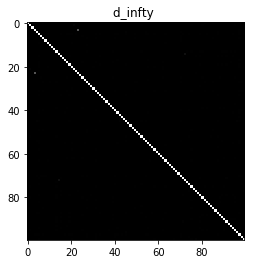

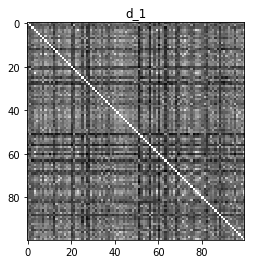

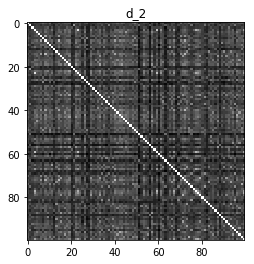

In [19]:
N=100
fig0 = plt.figure(frameon=False)
im0 = plt.imshow(dist(d_infty, N, x_train), cmap='gray_r')
_ = title('d_infty ')

fig1 = plt.figure(frameon=False)
im1 = plt.imshow(dist(d_1, N, x_train), cmap='gray_r')
_ = title('d_1')

fig2 = plt.figure(frameon=False)
im2 = plt.imshow(dist(d_2, N, x_train), cmap='gray_r')
_ = title('d_2')




# Assignment 4

Using only a distance matrix, apply the algorithm described above and compute the efficency of the algorithm, i.e., write a function that:

Given a distance matrix with shape `(N,N)`, constructed on the first `N` samples of the `x_train` set, count the number of failures of the **leave one out** strategy, i.e., 

- set `error_counter` to zero

- for every line `i` of the matrix:

    - find the index `j` (different from `i`) for which `D[i,k] >= D[i,j]` for all `k` different from `i` and `j`.

    - if `y_train[j]` is different from `y_train[i]`, increment by one `error_counter`

- return the error: error_counter/N

- apply the function above to the 3 different distance matrices you computed before


## Assignment 4: solution

We implemented efficiency using `np.argmin` per row. We replaced the diagonal `D[idx, idx] = D[idx, idx-1]` to avoid choosing its index as the minimum index. We measure its time and we concluded that it is not a time critical function thus further optimization is not requiered.

In [20]:
N = 400
D_infty = dist(d_infty, N, x_train)
D_1 = dist(d_1, N, x_train)
D_2 = dist(d_2, N, x_train)

# @time_this
def efficiency(N, D, labels):
    errors = 0
    for idx in range(N):
        # The diagonal value is the minimum by definition.
        # In order to avoid finding this unwanted minimum we do the following trick 
        # (we also avoided an if statement)
        D[idx, idx] = D[idx, idx-1] 
        min_indx = np.argmin(D[idx])
        D[idx, idx] = 0

        if not labels[idx] == labels[min_indx]: errors = errors + 1
    return errors/N

print(efficiency(N, D_infty, y_train))
print(efficiency(N, D_1, y_train))
print(efficiency(N, D_2, y_train))

0.4425
0.15
0.135



# Assignment 5

Run the algorithm implemented above for N=100,200,400,800,1600 on the three different distances, and plot the three error rate as a function of N (i.e., compute the distance matrix, and compute the efficiency associated to the distance matrix).

You should get an error like:
```
[[ 0.58      0.17      0.17    ]
 [ 0.52      0.145     0.135   ]
 [ 0.4425    0.15      0.135   ]
 [ 0.4       0.145     0.12875 ]
 [ 0.369375  0.1025    0.09375 ]]
```
where each column represents a different norm.

** In the next assignments, optional points are given if you manage to make the algorithm run faster, by pre-computing everything you can precompute in advance **

In [21]:
Ns = np.array([100,200,400,800])

# We generate a list of matrices with size N. Each new matrix is calculated from the previous entry.
# Matrices are suppose to be inserted in ascending order (dim-wise) 
def dist_list_N(func, N_list, group):
    dist_list = [] 
    dist_list.append(dist(func, N_list[0], group))
    for i in range(1, len(N_list)):
        dist_list.append(dist(func, N_list[i], group, dist_list[i-1]))
    return dist_list


# We measure the benefits of using the previous matrix to caculate the next one vs the older approach of 
# calculating everything from scratch.
with Timer() as t:
    print("Old algorithm")
    # Old way of doing it: I don't use the result of the previous dist matrix
    d_infty_errors = [efficiency(N, dist(d_infty, N, x_train), y_train) for N in Ns]
    d_1_errors = [efficiency(N, dist(d_1, N, x_train), y_train) for N in Ns]
    d_2_errors = [efficiency(N, dist(d_2, N, x_train), y_train) for N in Ns]

with Timer() as t:
    print("New algorithm")
    # New way of doing it: I use the result of the previous dist matrix
    d_infty_list = dist_list_N(d_infty, Ns, x_train)
    d_infty_errors_bis = [ efficiency(Ns[i], d_infty_list[i], y_train) for i in range(len(Ns))]
    d_1_list = dist_list_N(d_1, Ns, x_train)
    d_1_errors_bis = [ efficiency(Ns[i], d_1_list[i], y_train) for i in range(len(Ns))]
    d_2_list = dist_list_N(d_2, Ns, x_train)
    d_2_errors_bis = [ efficiency(Ns[i], d_2_list[i], y_train) for i in range(len(Ns))]


Old algorithm
Total time =  7.614701986312866
New algorithm
Total time =  5.73681116104126


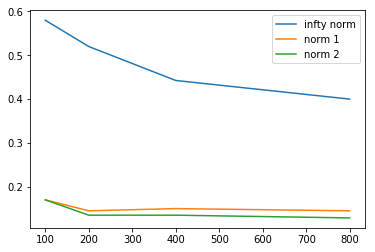

In [22]:
# fig = plt.figure()
plot(Ns, d_infty_errors,label = 'infty norm')
plot(Ns, d_1_errors, label = 'norm 1')
plot(Ns, d_2_errors, label = 'norm 2')
plt.legend()
plt.xlabel('N')
plt.ylabel('Error rate')
plt.show()

# Assignment 6

In principle, it should be possible to decrease the error by using a better norm. From the table above, it is clear that the L2 distance works better than the L1 distance, which works better than the Linfty distance.

However, *none of these distances exploit the fact that the image is a two-dimensional object*, and that there is information also in the **neighboring** information of the pixels. 

One way to exploit this, is to interpret the image as a continuous function with values between zero and one, defined on a square domain `\Omega=[0,27]x[0,27]`.

$$ f: \Omega \to R $$

- Implement a function that computes an approximation of the $H^1$ norm distance on the renormalized images. Given two images $f_1$ and $f_2$
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Define the $H^1$ distance as
    $$
    d_{H^1}(f_1,f_2) := \sqrt{\int_\Omega |\nabla(a-b)|^2+ (a-b)^2}
    $$
    using the algorithm you prefer (or the library you prefer) to compute the gradients and the integrals. Notice that $\nabla f = (\partial f/\partial x, \partial f/\partial y)$ is a vector valued function, and $|\nabla g|^2 := (\partial g/\partial x)^2 + (\partial g/\partial y)^2$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600


## Assignment 6: solution



In [23]:
def grad_list(image_set):
    grad = [np.gradient(im) for im in image_set]
    return grad


def intgrl_list(image_set):
    
    img_rows = image_set[0].shape[0]
    img_cols = image_set[0].shape[1]
    x = np.arange(img_rows)
    y = np.arange(img_cols)

    intgrl = [ simps(simps(im, y), x) for im in image_set]
    return intgrl

# having an array of precomputed gradients per image improves perfomance
grad_v = grad_list(x_train)
# same for the integrals of each image
intgrl_v = intgrl_list(x_train)

In [24]:
from scipy.integrate import simps
 

def d_h1(f1,f2, **kwargs):

    # check if you input 4 extra arguments:
    # i and j index of picture f1 and f2 respectively
    if len(kwargs.items()) != 4:
         raise TypeError("Missing arguments: gradient array and corresponding images indeces")
    
    # gradient of image i
    id1 = kwargs['id_f1']
    # gradient of image j
    id2 = kwargs['id_f2']
    # integral of image j
    intgrl = kwargs['intgrl']
    # integral of image j
    grad = kwargs['grad']
    
    x = np.arange(img_rows)
    y = np.arange(img_cols)

    a = f1/intgrl[id1]
    b = f2/intgrl[id2]
    
#     grad_ab = np.gradient(a-b)
    grad_ab = (grad[id1]/intgrl[id1]) - (grad[id2]/intgrl[id2])
    grad_abs_sq = np.square(grad_ab[0]) + np.square(grad_ab[1])  
    ab_sq = np.square(a-b)
    
    # we don't return the sqrt because it is monotonic and won't change our results (we save some computation time)
    return simps(simps(grad_abs_sq +  ab_sq, y), x)


print(d_h1(x_train[10], x_train[11], id_f1 =10, id_f2 = 11, grad = grad_v, intgrl = intgrl_v))

0.02889279489490389


In [25]:
Ns = np.array([100,200,400])
d_h1_errors = [efficiency(N, dist(d_h1, N, x_train, grad = grad_v, intgrl = intgrl_v), y_train) for N in Ns]

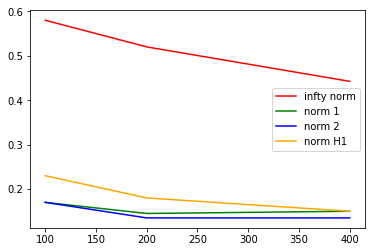

In [26]:
plot(Ns, d_infty_errors[:3], c='r', label = 'infty norm')
plot(Ns, d_1_errors[:3], c='g', label = 'norm 1')
plot(Ns, d_2_errors[:3], c='b', label = 'norm 2')
plot(Ns, d_h1_errors, c='orange', label = 'norm H1')
plt.xlabel('N')
plt.ylabel('Error rate')
plt.legend()
plt.show()

## Assignment 7

An even better improvement on the previous distance function is given by the following algorithm

- Given two images $f1$ and $f2$:
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Solve 
    $$
    -\Delta \phi = a - b \qquad \text{ in } \Omega
    $$
    $$
    \phi = 0 \text{ on } \partial\Omega
    $$
    - Define the *Monge Ampere* distance
    $$
    d_{MA}(f_1,f_2) = \int_\Omega (a+b)|\nabla \phi|^2
    $$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

## Assignment 7: solution

We used finite difference to discretize the Poisson problem. The resulting matrix is symmetric and positive definite.
To solve i,t we first tried iteratives methods (as the matrix is sparse and those usually are faster).
In particular we used Gauss-Seidel (we implemented it ourselves (see appendix)) or Conjugate Gradient.
Both methods were slower than a simple LU decomposition using `UMFPACK` and `Scipy Sparse`.
This is because the size of the matrix is small enough and a direct method is not too expensive. You can get a speed up because the matrix is small enough to fit in the cache of a laptop.

In [38]:
# Discretization of Poisson problem
rows=28
cols=28

ones = np.ones(rows*cols)
ones_sub = np.ones(cols)
ones_sub[-1] = 0
diagpm = np.tile(ones_sub, rows)

# Matrix of discrete Poisson problem (included de minus sign into the matrix):
A = np.diag(4*ones) + np.diag(-1*diagpm[:-1],-1) + np.diag(-1*diagpm[:-1],1) + np.diag(-1*ones[:-cols],-cols) + np.diag(-1*ones[:-cols],cols)
print()

In [39]:
from scipy import sparse
from scikits.umfpack import spsolve, splu
import numpy as np

# LU decomposition of matrix A
sA = sparse.csr_matrix(A)
lu = splu(sA)

As explained in exercise 6 for the gradient, we calculate the laplacians for all the images only once and store as a list. We then pass the list as an argument to the metric function `d_MA` avoiding repeating calculations when calculating the distance matrix.

In [63]:
def lapl_list(image_set):
    # Using LU decomposition of scipy.sparse.linalg (it used UMFPACK)
    # This was the faster one
    lapl = [lu.solve(im.reshape(784,1)).reshape(28,28) for im in image_set]
    return lapl

lapl_v = lapl_list(x_train)
# plt.imshow(x_train[0])
# plt.imshow(lapl_v[0])
# plt.show()

We define de MA norm as follows. We used simpson rule to solve the integration.

In [64]:
# Define norm d_MA

# @time_this
def d_MA(f1,f2,**kwargs):
    # check if you input 4 extra arguments:
    # i and j index of picture f1 and f2 respectively
    if len(kwargs.items()) != 4:
         raise TypeError("Missing arguments: laplacian array and image indices")
    
    # gradient of image i
    id1 = kwargs['id_f1']
    # gradient of image j
    id2 = kwargs['id_f2']
    # integral of image j
    intgrl = kwargs['intgrl']
    # integral of image j
    lapl = kwargs['lapl']
    
    x = np.arange(img_rows)
    y = np.arange(img_cols)
    
    a = f1/intgrl[id1]
    b = f2/intgrl[id2]
    
    # Reshapes don't introduce almost any overhead
    a_vec = a.reshape(784,1)
    b_vec = b.reshape(784,1)
    
    # Solve the laplace equation
    # With CG was slower than LU decomposition
    # x_start = np.ones(img_rows*img_cols)
    # x_start = x_start.reshape(784,1)
    # phi_vec = gauss_num_bis(A, a_vec - b_vec, x_start, 1000)
    # phi_vec = sparse.linalg.cg(A, a_vec-b_vec, x_start, 1e-8,1000)[0][:]

    # We end up using LU decomposition of scipy.sparse.linalg (it used UMFPACK)
    # We calculate it in an auxilary function to reduce operations
        
    phi = (lapl[id1]/intgrl[id1]) - (lapl[id2]/intgrl[id2])
    grad_phi = np.gradient(phi)
    grad_abs_sq = np.square(grad_phi[0]) + np.square(grad_phi[1])
    
    return simps(simps(grad_abs_sq*(a+b), y), x)

# N = 3
# dist(d_h1, N, x_train)

Ns = np.array([100,200,400])
# Ns = np.array([100])
d_MA_errors = [efficiency(N, dist(d_MA, N, x_train, lapl = lapl_v, intgrl = intgrl_v), y_train) for N in Ns]
print(d_MA_errors)

[0.24, 0.195, 0.145]


We computed the efficiency of the method and compared it with the results obtained using the other norms.
The graph shows that Monge Ampere distance performs worst than the others.

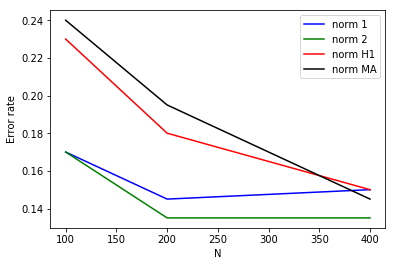

In [81]:
# plot the results of norm MA compared with the previous norms
plot(Ns, d_1_errors[:3], c='b', label = 'norm 1')
plot(Ns, d_2_errors[:3], c='g', label = 'norm 2')
plot(Ns, d_h1_errors[:3], c='r', label = 'norm H1')
plot(Ns, d_MA_errors[:], c='black', label = 'norm MA')
plt.xlabel('N')
plt.ylabel('Error rate')
plt.legend()
plt.show()

To better understand what the Monge Ampere distance is measuring we plotted some intermediate steps in the construction of the norm.
From  $-\Delta \hat{\phi} = a$ we can deduce that $\hat{\phi}$ is a diffuse representation of the image $a$ (we can think of the number as a source and the laplacian acting as a diffusion term with dirichlet boundary conditions = 0). 
The following figure shows exactly this for two random numbers:

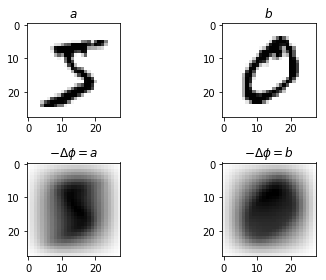

In [66]:
# Plot some of the results
x = np.arange(img_rows)
y = np.arange(img_cols)

f1 = x_train[0]
f2 = x_train[1]
intgrl_f1 = simps(simps(f1, y), x)
intgrl_f2 = simps(simps(f2, y), x)

a = f1/intgrl_f1
b = f2/intgrl_f2

a_vec = a.reshape(784,1)
b_vec = b.reshape(784,1)


fig1 = plt.figure()
ax1 = fig1.add_subplot(2,2,1) 
ax2 = fig1.add_subplot(2,2,2)
ax3 = fig1.add_subplot(2,2,3)
ax4 = fig1.add_subplot(2,2,4)

ax1.imshow(a,cmap='gray_r')
ax1.set_title("$a$")
ax2.imshow(b, cmap='gray_r')
ax2.set_title("$b$")
ax3.imshow(lu.solve(a_vec).reshape(28,28), cmap='gray_r')
ax3.set_title("$-\Delta \phi = a$")
ax4.imshow(lu.solve(b_vec).reshape(28,28), cmap='gray_r')
ax4.set_title("$-\Delta \phi = b$")
fig1.tight_layout()

With this in mind, the original $\phi$ is just the substraction of two diffuse images.
We also plotted the gradient to have a picture of what we are integrating.

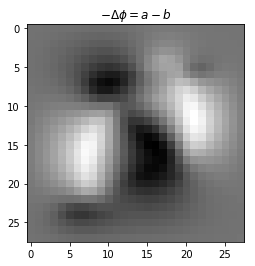

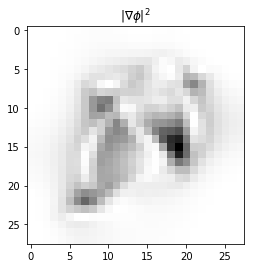

In [67]:
fig2 = plt.figure()
phi_mat = lu.solve(a_vec - b_vec).reshape(28,28)
grad_phi = np.gradient(phi_mat)
grad_abs_sq = np.square(grad_phi[0]) + np.square(grad_phi[1])

plt.imshow(lu.solve(a_vec - b_vec).reshape(28,28), cmap='gray_r')
plt.title("$-\Delta \phi = a - b$")

fig3 = plt.figure()
plt.imshow(grad_abs_sq, cmap='gray_r')
plt.title("$| \\nabla \phi|^2$")
plt.show()

The multiplying term $(a+b)$ in the Monge Ampere distance penalizes image superposition. We replaced this with two different terms:

* $(a-b)^2$
* $1$

and measure the performance of the modified norms.

In [75]:
# @time_this
def d_MA_ab_2(f1,f2, **kwargs):
    # check if you input 4 extra arguments:
    # i and j index of picture f1 and f2 respectively
    if len(kwargs.items()) != 4:
         raise TypeError("Missing arguments: laplacian array and image indices")
    
    # gradient of image i
    id1 = kwargs['id_f1']
    # gradient of image j
    id2 = kwargs['id_f2']
    # integral of image j
    intgrl = kwargs['intgrl']
    # integral of image j
    lapl = kwargs['lapl']
    
    x = np.arange(img_rows)
    y = np.arange(img_cols)
    
    a = f1/intgrl[id1]
    b = f2/intgrl[id2]
    
    # Reshapes don't introduce almost any overhead
    a_vec = a.reshape(784,1)
    b_vec = b.reshape(784,1)

    phi = (lapl[id1]/intgrl[id1]) - (lapl[id2]/intgrl[id2])
    grad_phi = np.gradient(phi)
    grad_abs_sq = np.square(grad_phi[0]) + np.square(grad_phi[1])
    
    
    return simps(simps(grad_abs_sq*(a-b)*(a-b), y), x)

In [76]:
# @time_this
def d_MA_1(f1,f2, **kwargs):
    # check if you input 4 extra arguments:
    # i and j index of picture f1 and f2 respectively
    if len(kwargs.items()) != 4:
         raise TypeError("Missing arguments: laplacian array and image indices")
    
    # gradient of image i
    id1 = kwargs['id_f1']
    # gradient of image j
    id2 = kwargs['id_f2']
    # integral of image j
    intgrl = kwargs['intgrl']
    # integral of image j
    lapl = kwargs['lapl']
    
    x = np.arange(img_rows)
    y = np.arange(img_cols)
    
    a = f1/intgrl[id1]
    b = f2/intgrl[id2]
    
    # Reshapes don't introduce almost any overhead
    a_vec = a.reshape(784,1)
    b_vec = b.reshape(784,1)
    
    # Laplace solution phi:
    phi = (lapl[id1]/intgrl[id1]) - (lapl[id2]/intgrl[id2])
    grad_phi = np.gradient(phi)
    grad_abs_sq = np.square(grad_phi[0]) + np.square(grad_phi[1])
    
    
    return simps(simps(grad_abs_sq, y), x)

In [78]:
# Calculate the errors for the modified d_MA norms
Ns = np.array([100,200,400])
# Ns = np.array([100])
d_MA_ab_2_errors = [efficiency(N, dist(d_MA_ab_2, N, x_train, lapl = lapl_v, intgrl = intgrl_v), y_train) for N in Ns]
d_MA_1_errors = [efficiency(N, dist(d_MA_1, N, x_train, lapl = lapl_v, intgrl = intgrl_v), y_train) for N in Ns]

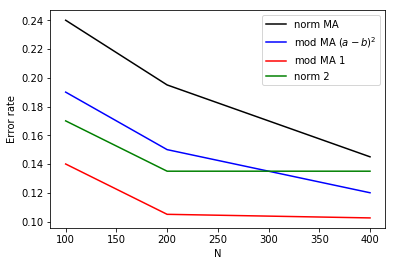

In [82]:
# plot the results for the modified d_MA norms
plot(Ns, d_MA_errors[:], c='black', label = 'norm MA')
plot(Ns, d_MA_ab_2_errors[:], c='b', label = 'mod MA $(a-b)^2$')
plot(Ns, d_MA_1_errors[:], c='r', label = 'mod MA $1$')
plot(Ns, d_2_errors[:3], c='g', label = 'norm 2')
plt.legend()
plt.xlabel('N')
plt.ylabel('Error rate')
plt.show()

Removing the $(a+b)$ showed the best performance. We obtained a better efficiency than the one obtained with norm 2.

## Assigment 8 (optional for DSSC, PhD and LM, Mandatory for MHPC)

Use the `BallTree` algorithm (https://en.wikipedia.org/wiki/Ball_tree), from the `sklearn` package, and construct a tree data structure **that uses one of the custom distances defined above**.

For each N in 3200,6400,12800,25600,51200, and for each distance defined above

- Build a tree using the first N entries of the training set `x_train`
- Construct a function that tests the efficiency on all the entries of the test set `x_test`:
    - for any image in `x_test`, call it `x_test[i]`, query the tree for the nearest neighbor (call it `k`), and assign as predicted digit the digit of the `x_train[k]` image, i.e., `y_train[k]`
    - check if `y_train[k]` is equal to the corresponding entry in `y_test[i]`. If not, increment a counter of the error
    - return the efficiency, i.e., `error_counter/len(x_test)`
- Plot, in a single graph, the error of each distance as a function of `N` (including labels, titles, etc.)

- Once you have the tree, experiment with different nearest neighbor algorithms, i.e., instead of taking only one nearest neighbor, take a larger number (a small number of your choice), and instead of returning the single closest digit, return the one with the largest number of occurrences. Plot the same graph you gave before, and see if you gain an improvement. Motivate all choices you have to make to get to the final answer.


**IF YOU DON'T HAVE ENOUGH COMPUTATIONAL POWER, RUN THE EXERCISES ONLY UP TO WHAT IS SUSTAINABLE FOR YOUR PC**

In [8]:
import numpy as np
from sklearn.neighbors import BallTree

In [9]:
def k_nearest_neighbors(kn, N, d_f, group, labels):
    tree = BallTree((group[:N]).reshape(N,28*28), leaf_size=2, metric=d_f, index = [1, 2])
    dist, ind = tree.query((group[:N]).reshape(N,28*28), k=kn)
    return ind, dist

def BallTree_efficiency(kn, N, d_f, group, labels):
    ind, _ = k_nearest_neighbors(kn, N, d_f, group, labels)
    k_nearest_labels = np.array([ [labels[ind[i,j]] for j in range(kn)] for i in arange(N) ])
    errors = 0
    for ima in range(N):
        counts = np.bincount(k_nearest_labels[ima,1:kn])
        if not k_nearest_labels[ima,0] == np.argmax(counts): errors += 1
    return [kn, N, errors/N]

In [10]:
kn = 3
Ns = np.array([10,20,40,80])
# d_infty_errors = np.array([BallTree_efficiency(kn, N, d_infty, x_train, y_train) for kn in range(2,7) for N in Ns])
# d_1_errors = np.array([BallTree_efficiency(kn, N, d_1, x_train, y_train) for kn in range(2,7) for N in Ns])
d_2_errors = np.array([BallTree_efficiency(kn, N, d_2, x_train, y_train) for kn in range(2,7) for N in Ns])
# d_h1_errors = np.array([BallTree_efficiency(kn, N, d_h1, x_train, y_train) for kn in range(2,7) for N in Ns])
print(d_2_errors)

TypeError: d_2() got an unexpected keyword argument 'index'

## Appendix: Extra calculations that we didn't use in the project

In [ ]:
# Own implementation of Gauss-Seidel

# import numpy as np
# from scipy.linalg import solve
# from scipy import sparse

# @time_this
# def gauss_mat(A, b, x ,n):
#     L = np.tril(A)
#     U = A - L
#     for i in range(n):
#         x = np.dot(np.linalg.inv(L), b - np.dot(U, x))
#     return x

# # Gauss-Seidel tailored specifically for poisson problem.
# @time_this
# def gauss_num(A, b, x, iteration):
    
#     # x is of dimension (28*28)
#     mat_dim = len(x)
#     col_dim = int(sqrt(len(x)))

    
#     for it in range(iteration):    
#         # First element (top left corner)
#         i=0
#         x[i] = 0.25*( b[i] - A[i][i+1]*x[i+1] - A[i][i+col_dim]*x[i+col_dim] )
        
#         # Boundary condition top
#         for i in range(1, col_dim):
#             x[i] = 0.25*( b[i] - A[i][i+1]*x[i+1] - A[i][i-1]*x[i-1] - A[i][i+col_dim]*x[i+col_dim] )
        
#         for i in range(col_dim, mat_dim-col_dim):
#             x[i] = 0.25*( b[i] - A[i][i+1]*x[i+1] - A[i][i-1]*x[i-1] - A[i][i-col_dim]*x[i-col_dim] - A[i][i+col_dim]*x[i+col_dim] )
    
#         # Boundary condition bot
#         for i in range(mat_dim-col_dim, mat_dim-1):
#             x[i] = 0.25*( b[i] - A[i][i+1]*x[i+1] - A[i][i-1]*x[i-1] - A[i][i-col_dim]*x[i-col_dim] )

#         # Last element (bottom right corner)
#         i=i+1
#         x[i] = 0.25*( b[i] - A[i][i-1]*x[i-1] - A[i][i-col_dim]*x[i-col_dim] )
    
#     return x

# # Gauss-Seidel without using matrix A (We kept it as an argument to make the functions compatible)
# @time_this
# def gauss_num_bis(A, b, x, max_iter):
#     # Parameters:
#     eps=1e-8
    
#     # x is of dimension (28*28)
#     mat_dim = len(x)
#     col_dim = int(sqrt(len(x)))
#     row_dim = col_dim
# #     x_prev = np.empty((mat_dim,1))
#     x_prev = np.copy(x)
    
#     for it in range(max_iter):    
#         # First element (top left corner)
#         i=0
#         x[i] = 0.25*( b[i] - (-1.)*x[i+1] - (-1.)*x[i+col_dim] )
        
#         # Boundary condition top
#         for i in range(1, col_dim):
#             x[i] = 0.25*( b[i] - (-1.)*x[i+1] - (-1.)*x[i-1] - (-1.)*x[i+col_dim] )
        
#         for i in range(1, row_dim-1):
#             x[i*col_dim ] = 0.25*( b[i*col_dim ] - (-1.)*x[i*col_dim +1] - (-1.)*x[i*col_dim -col_dim] - (-1.)*x[i*col_dim +col_dim] )
#             for j in range(1, col_dim-1):
#                 x[i*col_dim + j] = 0.25*( b[i*col_dim + j] - (-1.)*x[i*col_dim + j+1] - (-1.)*x[i*col_dim + j-1] - (-1.)*x[i*col_dim + j-col_dim] - (-1.)*x[i*col_dim + j+col_dim] )

#             x[i*col_dim + col_dim-1 ] = 0.25*( b[i*col_dim + col_dim-1 ] - (-1.)*x[i*col_dim + col_dim-1 -1] - (-1.)*x[i*col_dim + col_dim-1 -col_dim] - (-1.)*x[i*col_dim + col_dim-1 +col_dim] )
    
#         # Boundary condition bot
#         for i in range(mat_dim-col_dim, mat_dim-1):
#             x[i] = 0.25*( b[i] - (-1.)*x[i+1] - (-1.)*x[i-1] - (-1.)*x[i-col_dim] )

#         # Last element (bottom right corner)
#         i=i+1
#         x[i] = 0.25*( b[i] - (-1.)*x[i-1] - (-1.)*x[i-col_dim] )
        

#         if all( [abs(x[0]-x_prev[0]) < eps for j in range(mat_dim)]):
#             print('iteration: ', it, eps)
#             return x     
#         x_prev = np.copy(x)
        
        
#     raise ValueError('Solution does not converge')

    
# f1 = x_train[10]
# f2 = x_train[11]
# x = np.arange(img_rows)
# y = np.arange(img_cols)

# intgrl_f1 = simps(simps(f1, y), x)
# intgrl_f2 = simps(simps(f2, y), x)

# a = f1/intgrl_f1
# b = f2/intgrl_f2

# a_vec = a.reshape(784,1)
# b_vec = b.reshape(784,1)

# x_start = np.ones(img_rows*img_cols)
# x_start = x_start.reshape(784,1)

# num_bis = gauss_num_bis(A, a_vec - b_vec, x_start, 1000)

# x_start = np.ones(img_rows*img_cols)
# x_start = x_start.reshape(784,1)
# num = gauss_num(A, a_vec - b_vec, x_start, 1000)

# x_start = np.ones(img_rows*img_cols)
# x_start = x_start.reshape(784,1)

# cg_num = time_this(sparse.linalg.cg)
# cg_res = cg_num(A, a_vec-b_vec, x_start, 1e-8,1000)



# # x_start = np.ones(img_rows*img_cols)
# # x_start = x_start.reshape(784,1)
# # mat = gauss_mat(A, a_vec - b_vec , x_start, 1200)



# # print("mat gauss: ", mat[:10])
# print("num gauss: \n", num[:10])
# print("num_bis gauss: \n", num_bis[:10])
# print("cg num: \n", cg_res[0][:10])
# # print(num == mat)

